### Part - I: Importing Required Modules/ Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf 
import keras
print(tf.__version__)
print(keras.__version__)
print(pd.__version__)
print(np.__version__)

2.6.0
2.6.0
1.3.4
1.19.5


In [2]:
# custom imports 
from nn_globals import *
from nn_plotting import gaus, fit_gaus, corr_plot

### Part- II: Data Preprocessing

In [3]:
def _handle_nan_in_x(x):
    x[np.isnan(x)] = 0.0
    x[x==-999.0] = 0.0
    return x

def _zero_out_x(x):
    x = 0.0
    return x
    
def _fixME1Ring(x):
    for i in range(len(x)):
        if (x[i,0] != 0.0): x[i,18] = x[i,18] + 1
    return x   

def muon_data(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, correct_for_eta=False):
    try:
        logger.info('Loading muon data from {0} ...'.format(filename))
        loaded = np.load(filename)
        the_variables = loaded['variables']
        the_parameters = loaded['parameters']
        # print(the_variables.shape)
        the_variables = the_variables[:nentries]
        the_parameters = the_parameters[:nentries]
        logger.info('Loaded the variables with shape {0}'.format(the_variables.shape))
        logger.info('Loaded the parameters with shape {0}'.format(the_parameters.shape))
    except:
        logger.error('Failed to load data from file: {0}'.format(filename))

    assert(the_variables.shape[0] == the_parameters.shape[0])
    _handle_nan_in_x(the_variables)
      #_fixME1Ring(the_variables)
    _handle_nan_in_x(the_parameters)
    mask = np.logical_or(np.logical_or( np.logical_or((the_variables[:,23] == 11), (the_variables[:,23] == 13)), (the_variables[:,23] == 14)),(the_variables[:,23] == 15)) 

    the_variables = the_variables[mask]  
    the_parameters = the_parameters[mask]  
    assert(the_variables.shape[0] == the_parameters.shape[0])

    x = the_variables[:,0:23]
    y = reg_pt_scale*the_parameters[:,0]
    phi = the_parameters[:,1] 
    eta = the_parameters[:,2] 
    vx = the_parameters[:,3] 
    vy = the_parameters[:,4] 
    vz = the_parameters[:,5]      
    dxy = vy * np.cos(phi) - vx * np.sin(phi) 
    dz = vz
    w = np.abs(y)/0.2 + 1.0
    x_mask = the_parameters[:,5]
    x_road = the_parameters[:,5] 
    _zero_out_x(x_mask)
    _zero_out_x(x_road)  
    logger.info('Loaded the encoded variables with shape {0}'.format(x.shape))
    logger.info('Loaded the encoded parameters with shape {0}'.format(y.shape))

    return x, y, dxy, dz, w, x_mask, x_road

def muon_data_split(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, test_size=0.5, correct_for_eta=False):
    x, y, dxy, dz, w, x_mask, x_road = muon_data(filename, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, correct_for_eta=correct_for_eta)

    # Split dataset in training and testing
    x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = train_test_split(x, y, dxy, dz, w, x_mask, x_road, test_size=test_size)
    logger.info('Loaded # of training and testing events: {0}'.format((x_train.shape[0], x_test.shape[0])))

    # Check for cases where the number of events in the last batch could be too few
    validation_split = 0.1
    train_num_samples = int(x_train.shape[0] * (1.0-validation_split))
    val_num_samples = x_train.shape[0] - train_num_samples
    batch_size = 128
    if (train_num_samples%batch_size) < 100:
        logger.warning('The last batch for training could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
        logger.warning('Try this formula: int(int({0}*{1})*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
    train_num_samples = int(x_train.shape[0] * 2 * (1.0-validation_split))
    val_num_samples = x_train.shape[0] - train_num_samples
    batch_size = 128
    if (train_num_samples%batch_size) < 100:
        logger.warning('The last batch for training after mixing could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
        logger.warning('Try this formula: int(int({0}*{1})*2*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
    return x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test

# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train_displ, x_test_displ, y_train_displ, y_test_displ, dxy_train_displ, dxy_test_displ, dz_train_displ, dz_test_displ, \
w_train_displ, w_test_displ, x_mask_train_displ, x_mask_test_displ, x_road_train_displ, x_road_test_displ = \
      muon_data_split(infile_muon_displ, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_size=0.315)

y_train_displ = np.abs(y_train_displ)
y_test_displ = np.abs(y_test_displ)

[INFO    ] Loading muon data from ./NN_input_params_FlatXYZ.npz ...
[INFO    ] Loaded the variables with shape (19300000, 25)
[INFO    ] Loaded the parameters with shape (19300000, 6)
[INFO    ] Loaded the encoded variables with shape (3284620, 23)
[INFO    ] Loaded the encoded parameters with shape (3284620,)
[INFO    ] Loaded # of training and testing events: (2249964, 1034656)
[WARNING ] The last batch for training could be too few! (2024967%128)=7. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*0.9) % 128
[WARNING ] The last batch for training after mixing could be too few! (4049935%128)=15. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*2*0.9) % 128


### Part-III: Use the cells in this section for data exploration

In [ ]:
# cols = ["dphi_1","dphi_2","dphi_3","dphi_4","dphi_5","dphi_6",
#        "dtheta_1","dtheta_2","dtheta_3","dtheta_4","dtheta_5", "dtheta_6",
#        "bend_1","bend_2","bend_3","bend_4",
#        "track theta"]

# x = np.concatenate((x_train_displ,x_test_displ),axis=0)
# y = np.concatenate((y_train_displ,y_test_displ),axis=0)
# dxy = np.concatenate((dxy_train_displ,dxy_test_displ),axis=0)

# corr_plot(x,y,dxy,columns = cols)

### Part-IV: Build the custom model

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, TerminateOnNaN, EarlyStopping

# project-specific imports
from nn_evaluate import huber_loss, k_fold_validation
from nn_training import lr_schedule
from nn_pruning_module_support import loading_trained_model
from nn_training_pruned_model import (generate_layer_masks, 
                                      create_sparse_model,
                                      train_sparse_model)

In [5]:
baseline = loading_trained_model(filepath = "models/",
                                 model_filename = "model")
baseline.summary()

2021-12-02 14:34:37.553389: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-02 14:34:37.553703: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Loaded model from disk
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 23)                92        
_________________________________________________________________
dense (Dense)                (None, 20)                460       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
activation (Activation)      (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                300       
_________________________________________________________________
batch_normalization_2 (Batch (None, 15)                60        
_________________________________________________________________
act

In [ ]:
# PRUNING CYCLE - I

l1_reg = 0.0
l2_reg = 0.0
eps = 1e-4
momentum = 0.9
lr = 1e-4
retrain_batch_size = 1000
sparsity = 0.10
retrain_epochs = 50
clipnorm = 10.0

adam = Adam(lr=lr, clipnorm=clipnorm)
lr_decay = LearningRateScheduler(lr_schedule, verbose=1)
terminate_on_nan = TerminateOnNaN()
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0,
                               mode='auto', baseline=None, restore_best_weights=False)

pruned_model_10 = create_sparse_model(model = baseline,
                                       input_dim = nvariables,
                                       output_dim = 2,
                                       k_sparsity = sparsity,
                                       bn_epsilon = eps,
                                       bn_momentum = momentum,
                                       l1_reg = l1_reg,
                                       l2_reg = l1_reg,
                                       kernel_initializer="glorot_uniform",
                                       optimizer = adam)
pruned_model_10, history_10 = train_sparse_model(sparse_model = pruned_model_10,
                                                   x = x_train_displ,
                                                   y = y_train_displ,
                                                   dxy = dxy_train_displ,
                                                   retrain_epochs = retrain_epochs,
                                                   batch_size = retrain_batch_size,
                                                   callbacks=[lr_decay, 
                                                              early_stopping, 
                                                              terminate_on_nan],
                                                   verbose = True,
                                                   validation_split=0.1)

In [ ]:
k_fold_validation(model = pruned_model_10, 
                  x = x, 
                  y = y, 
                  dxy = dxy, 
                  folds =50)

In [ ]:
# PRUNING CYCLE - II

lr = 2.5e-4
clipnorm = 10.
eps = 1e-4
momentum = 0.9
retrain_epochs = 75
retrain_batch_size = 1000
l1_reg = 0.0
l2_reg = 0.0
sparsity = 0.20
adam = Adam(lr=lr, clipnorm=clipnorm)
lr_decay = LearningRateScheduler(lr_schedule, verbose=1)
terminate_on_nan = TerminateOnNaN()
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0,
                               mode='auto', baseline=None, restore_best_weights=False)

pruned_model_20 = create_sparse_model(model = pruned_model_10,
                                       input_dim = nvariables,
                                       output_dim = 2,
                                       k_sparsity = sparsity,
                                       bn_epsilon = eps,
                                       bn_momentum = momentum,
                                       l1_reg = l1_reg,
                                       l2_reg = l1_reg,
                                       kernel_initializer="glorot_uniform",
                                       optimizer = adam)

pruned_model_20, history_20 = train_sparse_model(sparse_model = pruned_model_20,
                                                   x = x_train_displ,
                                                   y = y_train_displ,
                                                   dxy = dxy_train_displ,
                                                   retrain_epochs = retrain_epochs,
                                                   batch_size = retrain_batch_size,
                                                   callbacks=[lr_decay, 
                                                              early_stopping, 
                                                              terminate_on_nan],
                                                   verbose = True,
                                                   validation_split=0.1)

In [ ]:
k_fold_validation(model = pruned_model_20, 
                  x = x, 
                  y = y, 
                  dxy = dxy, 
                  folds =50)

In [ ]:
# PRUNING CYCLE - III

lr = 3e-4
clipnorm = 10.
eps = 1e-4
momentum = 0.9
retrain_epochs = 75
retrain_batch_size = 800
l1_reg = 0.0
l2_reg = 0.0

adam = Adam(lr=lr, clipnorm=clipnorm)
lr_decay = LearningRateScheduler(lr_schedule, verbose=1)
terminate_on_nan = TerminateOnNaN()
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0,
                               mode='auto', baseline=None, restore_best_weights=False)

pruned_model_30 = create_sparse_model(model = pruned_model_20,
                                       input_dim = nvariables,
                                       output_dim = 2,
                                       k_sparsity = sparsity,
                                       bn_epsilon = eps,
                                       bn_momentum = momentum,
                                       l1_reg = l1_reg,
                                       l2_reg = l1_reg,
                                       kernel_initializer="glorot_uniform",
                                       optimizer = adam)

pruned_model_30, history_30 = train_sparse_model(sparse_model = pruned_model_30,
                                                   x = x_train_displ,
                                                   y = y_train_displ,
                                                   dxy = dxy_train_displ,
                                                   retrain_epochs = retrain_epochs,
                                                   batch_size = retrain_batch_size,
                                                   callbacks=[lr_decay, 
                                                              early_stopping, 
                                                              terminate_on_nan],
                                                   verbose = True,
                                                   validation_split=0.1)

In [ ]:
k_fold_validation(model = pruned_model_30, 
                  x = x, 
                  y = y, 
                  dxy = dxy, 
                  folds =50)

In [ ]:
# PRUNING CYCLE - IV

lr = 5e-4
clipnorm = 10.
eps = 1e-4
momentum = 0.8
retrain_epochs = 100
retrain_batch_size = 800
l1_reg = 0.0
l2_reg = 0.0

adam = Adam(lr=lr, clipnorm=clipnorm)
lr_decay = LearningRateScheduler(lr_schedule, verbose=1)
terminate_on_nan = TerminateOnNaN()
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0,
                               mode='auto', baseline=None, restore_best_weights=False)

pruned_model_40 = create_sparse_model(model = pruned_model_30,
                                       input_dim = nvariables,
                                       output_dim = 2,
                                       k_sparsity = sparsity,
                                       bn_epsilon = eps,
                                       bn_momentum = momentum,
                                       l1_reg = l1_reg,
                                       l2_reg = l1_reg,
                                       kernel_initializer="glorot_uniform",
                                       optimizer = adam)

pruned_model_40, history_40 = train_sparse_model(sparse_model = pruned_model_40,
                                                   x = x_train_displ,
                                                   y = y_train_displ,
                                                   dxy = dxy_train_displ,
                                                   retrain_epochs = retrain_epochs,
                                                   batch_size = retrain_batch_size,
                                                   callbacks=[lr_decay, 
                                                              early_stopping, 
                                                              terminate_on_nan],
                                                   verbose = True,
                                                   validation_split=0.1)

In [ ]:
k_fold_validation(model = pruned_model_40, 
                  x = x, 
                  y = y, 
                  dxy = dxy, 
                  folds =50)

In [ ]:
# PRUNING CYCLE - V

lr = 7.5e-4
clipnorm = 10.
eps = 1e-4
momentum = 0.9
retrain_epochs = 125
retrain_batch_size = 500
l1_reg = 0.0
l2_reg = 0.0
sparsity = 0.50

adam = Adam(lr=lr, clipnorm=clipnorm)
lr_decay = LearningRateScheduler(lr_schedule, verbose=1)
terminate_on_nan = TerminateOnNaN()
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0,
                               mode='auto', baseline=None, restore_best_weights=False)

pruned_model_50 = create_sparse_model(model = pruned_model_40,
                                       input_dim = nvariables,
                                       output_dim = 2,
                                       k_sparsity = sparsity,
                                       bn_epsilon = eps,
                                       bn_momentum = momentum,
                                       l1_reg = l1_reg,
                                       l2_reg = l1_reg,
                                       kernel_initializer="glorot_uniform",
                                       optimizer = adam)

pruned_model_50, history_50 = train_sparse_model(sparse_model = pruned_model_50,
                                                   x = x_train_displ,
                                                   y = y_train_displ,
                                                   dxy = dxy_train_displ,
                                                   retrain_epochs = retrain_epochs,
                                                   batch_size = retrain_batch_size,
                                                   callbacks=[lr_decay, 
                                                              early_stopping, 
                                                              terminate_on_nan],
                                                   verbose = True,
                                                   validation_split=0.1)

In [ ]:
k_fold_validation(model = pruned_model_50, 
                  x = x, 
                  y = y, 
                  dxy = dxy, 
                  folds =50)

In [ ]:
# PRUNING CYCLE - VI

lr = 3.5e-3
clipnorm = 10.
eps = 1e-4
momentum = 0.9
retrain_epochs = 200
retrain_batch_size = 1000
l1_reg = 0.0
l2_reg = 0.0
sparsity = 0.60

adam = Adam(lr=lr, clipnorm=clipnorm)
lr_decay = LearningRateScheduler(lr_schedule, verbose=1)
terminate_on_nan = TerminateOnNaN()
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0,
                               mode='auto', baseline=None, restore_best_weights=False)

pruned_model_60 = create_sparse_model(model = pruned_model_50,
                                       input_dim = nvariables,
                                       output_dim = 2,
                                       k_sparsity = sparsity,
                                       bn_epsilon = eps,
                                       bn_momentum = momentum,
                                       l1_reg = l1_reg,
                                       l2_reg = l1_reg,
                                       kernel_initializer="glorot_uniform",
                                       optimizer = adam)

pruned_model_60, history_60 = train_sparse_model(sparse_model = pruned_model_60,
                                                   x = x_train_displ,
                                                   y = y_train_displ,
                                                   dxy = dxy_train_displ,
                                                   retrain_epochs = retrain_epochs,
                                                   batch_size = retrain_batch_size,
                                                   callbacks=[lr_decay, 
                                                              early_stopping, 
                                                              terminate_on_nan],
                                                   verbose = True,
                                                   validation_split=0.1)

In [ ]:
k_fold_validation(model = pruned_model_60, 
                  x = x, 
                  y = y, 
                  dxy = dxy, 
                  folds =50)

### Part- V: Saving and Loading the Trained Model

In [ ]:
# from custom_dense_layer import MaskedDense
# from keras.initializers import glorot_uniform
# from keras.regularizers import l1_l2
# from nn_pruning_module_support import saving_pruned_model, loading_pruned_model

In [ ]:
# saving_pruned_model(model = pruned_model_10, 
#                     filepath='/Users/gpradhan/Desktop/Pruning L1T Muon Trigger Regression Model /models', 
#                     model_filename='custom_model_X')

In [ ]:
# loaded_pruned_model = loading_pruned_model(filepath='/Users/gpradhan/Desktop/Pruning L1T Muon Trigger Regression Model /models', 
#                                             model_filename='custom_model_X',
#                                             custom_objects=
#                                                 {'GlorotUniform': glorot_uniform(), 
#                                                         "MaskedDense": MaskedDense, 
#                                                         "L1L2": l1_l2()}
#                                             )
# loaded_pruned_model.summary()

In [ ]:
# # Test the loaded model perf
# k_fold_validation(model = loaded_pruned_model, 
#                   x = x, 
#                   y = y, 
#                   dxy = dxy, 
#                   folds =50)

### Part VI: Model Performance Analysis

In [15]:
from nn_pruning_module_support import __generate_delta_plots__

2021-12-02 15:48:43.447975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
[INFO    ] # of entries: 1034656, mean: 0.03819067292836008, std: 0.18065615682381828
[INFO    ] gaus fit (a, mu, sig): [ 5.92655175e+04 -8.21854052e-04  2.27735463e-01]


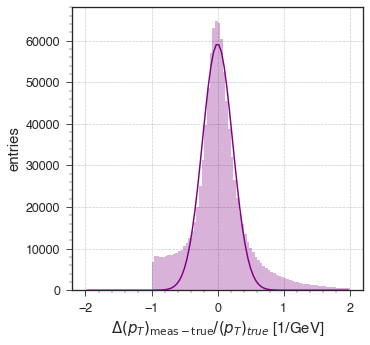

[INFO    ] # of entries: 150277, mean: 0.10727048662086189, std: 10.056963310843617
[INFO    ] gaus fit (a, mu, sig): [1.01852743e+04 8.81886144e-02 5.28068239e+00]


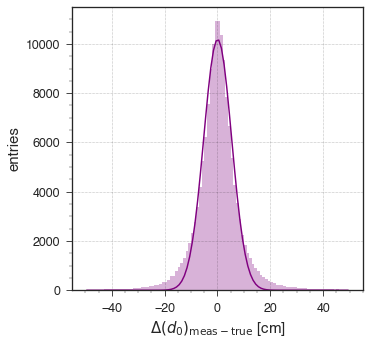

2021-12-02 15:48:44.455265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
[INFO    ] # of entries: 1034656, mean: 0.0204225738368893, std: 0.18088404864125185
[INFO    ] gaus fit (a, mu, sig): [ 5.95303819e+04 -1.16955839e-02  2.28002823e-01]


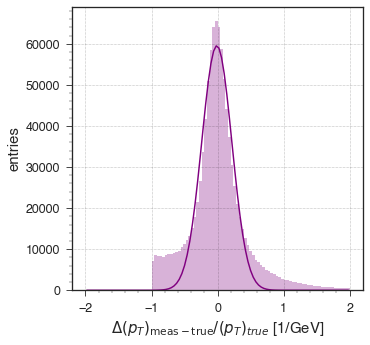

[INFO    ] # of entries: 150277, mean: -0.28796878699313383, std: 10.17625007707107
[INFO    ] gaus fit (a, mu, sig): [ 9.97242419e+03 -3.39694470e-01  5.39912435e+00]


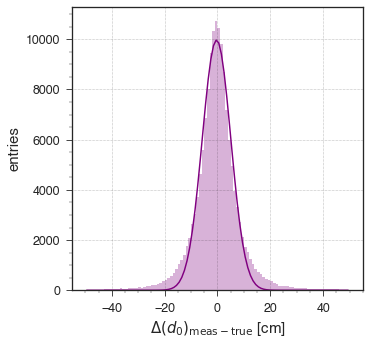

In [16]:
for pmodel in pruned_models:
    __generate_delta_plots__(model = pmodel,
                            x = x_test_displ,
                            y = y_test_displ,
                            dxy = dxy_test_displ,
                            color = "purple")